# Access to mental health services by the BME population in the UK

People from ethnic minorities in the UK, particularly of Asian background, are said to be less likely to access mental health services provide by the NHS.
This analysis sets out to see if there is indeed a disparity between services accessed by the asian population vs the white population, and will statistically test if there is a significance difference in the two groups.

In [31]:
from matplotlib import pyplot as plt
import pandas as pd
import seaborn as sns
from scipy.stats import chi2_contingency
import numpy as np 
import requests
import pprint
import plotly
import plotly.graph_objects as go

%matplotlib inline

#The below is for online saving of plotly figures
import os

if not os.path.exists("images"):
    os.mkdir("images")

The first step to analyising the data is to load and inspect the data to then be able to clean it, ready for analysis. 

Whilst loading in the csv, we will define the value of the NaN values in the file, which are '-' and '*' so that we can easily fill in these values later. 

In [4]:
data = pd.read_csv('BME Mental Health Stats.csv', na_values=['-','*'])
print(data.head())

  Reporting period Breakdown     Level Level description  \
0          2014/15  National  National           England   
1          2014/15  National  National           England   
2          2014/15  National  National           England   
3          2014/15  National  National           England   
4          2014/15  National  National           England   

                       Ethnicity group Rate per 100,000 Population  \
0               Asian or Asian British         1,651.30  4,143,400   
1           Any other Asian background         2,039.00    819,400   
2                          Bangladeshi         1,839.60    436,500   
3                              Chinese            755.2    379,500   
4                               Indian         1,455.40  1,395,700   

  Number using service  
0               68,419  
1               16,708  
2                8,030  
3                2,866  
4               20,313  


Diagnose the data further.

In [5]:
data.info()

data.dtypes


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26288 entries, 0 to 26287
Data columns (total 8 columns):
Reporting period        26288 non-null object
Breakdown               26288 non-null object
Level                   26288 non-null object
Level description       26288 non-null object
Ethnicity group         26288 non-null object
Rate per 100,000        16491 non-null object
Population              21200 non-null object
Number using service    20131 non-null object
dtypes: object(8)
memory usage: 1.6+ MB


Reporting period        object
Breakdown               object
Level                   object
Level description       object
Ethnicity group         object
Rate per 100,000        object
Population              object
Number using service    object
dtype: object

To make the column names more accessible to manipulation, I will get rid of all the spaces and commas and change them to underscores.

In [6]:
data.columns = [c.replace(' ', '_') for c in data.columns]
data.columns = [c.replace(',', '_') for c in data.columns]

print(data.columns)

Index(['Reporting_period', 'Breakdown', 'Level', 'Level_description',
       'Ethnicity_group', 'Rate_per_100_000', 'Population',
       'Number_using_service'],
      dtype='object')


We can see from the above, that before we analyse the data, we will also need to change the types of values and manipulate the strings to be able to perform numerical calculations on.

The data doesn't need reshaping. (We want each variable as a separate column and each row as a separate observation which we already have with ethnicity as a variable and the different ethnicities as spearate observations in rows.

However we do need to delete the rows that contain the totals, and separate out the national level stats when we do regional analysis so that we are working from 2 different tables. 

First, let's get rid of all (',') in the data and turn into numerical data (integer/float).

In [7]:
data.Rate_per_100_000 = data['Rate_per_100_000'].replace('[\,,]', '', regex = True)

data.Population = data['Population'].replace('[\,,]', '', regex = True)

data.Number_using_service = data['Number_using_service'].replace('[\,,]', '', regex = True)

We get an error when trying to convert the values to numerical data, due to missing values in the columns, so we first need to fix this. We can fill all NaN with '0'.

In [8]:
data.Population = data['Population'].fillna(0)
data.Population = pd.to_numeric(data.Population)

data.Number_using_service = data['Number_using_service'].fillna(0)
data.Number_using_service = pd.to_numeric(data.Number_using_service)

print(data.columns)

Index(['Reporting_period', 'Breakdown', 'Level', 'Level_description',
       'Ethnicity_group', 'Rate_per_100_000', 'Population',
       'Number_using_service'],
      dtype='object')


Next we need to delete any rows which dont make sense and will skew the data if left in. ie. the total rows and the header rows.

We should also check for duplicate rows at this point.

In [9]:
strings_to_delete = ['Total for Black and Minority Ethnic groups', 'Grand total',\
                     'Total for Black and Minority Ethnic groups', 'Asian or Asian British',\
                     'Black or black British', 'Mixed', 'Not known', 'Not stated',\
                     'Other ethnic groups','Unspecified', 'White'] 
data = data[~data['Ethnicity_group'].isin(strings_to_delete)]

data.duplicated()


1        False
2        False
3        False
4        False
5        False
         ...  
26282    False
26283    False
26284    False
26285    False
26287    False
Length: 18656, dtype: bool

It looks like it could be beneficial to add a column into the dataframe which calculates the percentage.

In [43]:
data['Percentage_using_service']=((data.Number_using_service)/(data.Population))*100

Now we will split the dataframe into 2 separate dataframes, one for national level data and one for regional level data.

In [44]:
national_data = data[data.Level == 'National']
regional_data = data[data.Level != 'National']


Now let's start to look at the data and analyse it!
 
First let's look at the national level data and compare the percentage of the population of ethnicity groups who used metal health services.

In [45]:
print(national_data.head())

  Reporting_period Breakdown     Level Level_description  \
1          2014/15  National  National           England   
2          2014/15  National  National           England   
3          2014/15  National  National           England   
4          2014/15  National  National           England   
5          2014/15  National  National           England   

                       Ethnicity_group Rate_per_100_000  Population  \
1           Any other Asian background          2039.00      819400   
2                          Bangladeshi          1839.60      436500   
3                              Chinese            755.2      379500   
4                               Indian          1455.40     1395700   
5                            Pakistani          1843.20     1112300   

   Number_using_service  Percentage_using_service  
1                 16708                  2.039053  
2                  8030                  1.839633  
3                  2866                  0.755204  
4   

We will create a bar graph to visualise the comparison between the ethnicity groups using the service.

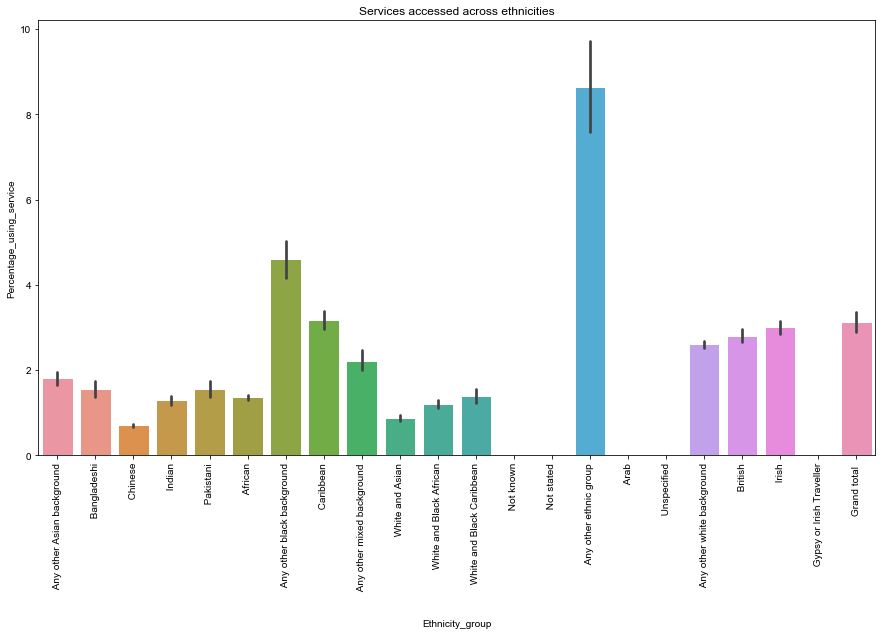

In [13]:
plt.figure(figsize=(15,8))
plt.title("Services accessed across ethnicities")
plt.xlabel("Ethnicity")
plt.ylabel("Percentage of population using services")
sns.set_style('darkgrid')
sns.set_context('notebook')
ax = sns.barplot(data = national_data, x = 'Ethnicity_group', y = 'Percentage_using_service')
ax.set_xticklabels(national_data.Ethnicity_group, rotation = 90)
plt.show()

Combine the ethnicities into asian/black etc. Create a subset.

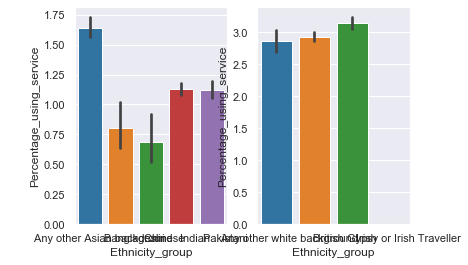

In [54]:
Pakistani_data = regional_data[regional_data.Ethnicity_group.str.contains('Pakistani')]

British_data = regional_data[regional_data.Ethnicity_group.str.contains('British')]

asian_search_values = ['Pakistani', 'Indian', 'Chinese', 'Bangladeshi', 'Any other Asian background']
asian_regional_data = regional_data[regional_data.Ethnicity_group.str.contains('|'.join(asian_search_values))]

white_search_values = ['British', 'Irish', 'Any other white background']
white_regional_data = regional_data[regional_data.Ethnicity_group.str.contains('|'.join(white_search_values))]

plt.subplot(1,2,1)
sns.barplot(data=asian_regional_data, x = 'Ethnicity_group', y = 'Percentage_using_service')
plt.subplot(1,2,2)
sns.barplot(data=white_regional_data, x = 'Ethnicity_group', y = 'Percentage_using_service')
plt.show()

In [55]:
asian_mean_using_service = asian_regional_data["Percentage_using_service"].mean()
white_mean_using_service = white_regional_data["Percentage_using_service"].mean()

asian_mean_using_service, white_mean_using_service

(1.077967914459348, 2.2709889127928076)

1.1% of the asian population vs 2.3% of the white population are accessing mental health services on average.

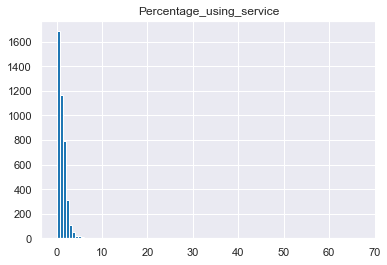

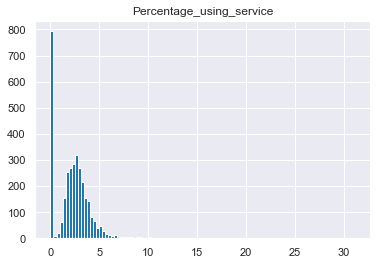

In [64]:
asian_regional_data.hist(column="Percentage_using_service", bins = 100)
white_regional_data.hist(column="Percentage_using_service", bins = 100)
plt.show()

Both distrubutions are skewed right

Let's now test the hypothesis: 

H0: There is no difference between the proportion of health servcies accessed by Asian population vs the White population.


In [57]:
asian_regional_data

,Reporting_period,Breakdown,Level,Level_description,Ethnicity_group,Rate_per_100_000,Population,Number_using_service,Percentage_using_service
32,2014/15,CCG,00C,NHS Darlington CCG,Any other Asian background,1298.70,500,5,1.000000
33,2014/15,CCG,00C,NHS Darlington CCG,Bangladeshi,1147.20,500,5,1.000000
34,2014/15,CCG,00C,NHS Darlington CCG,Chinese,NaN,300,0,0.000000
35,2014/15,CCG,00C,NHS Darlington CCG,Indian,1790.60,700,15,2.142857
36,2014/15,CCG,00C,NHS Darlington CCG,Pakistani,NaN,100,0,0.000000
...,...,...,...,...,...,...,...,...,...
26258,2011/12,CCG,99Q,NHS South Devon and Torbay CCG,Any other Asian background,NaN,800,0,0.000000
26259,2011/12,CCG,99Q,NHS South Devon and Torbay CCG,Bangladeshi,NaN,200,0,0.000000
26260,2011/12,CCG,99Q,NHS South Devon and Torbay CCG,Chinese,NaN,600,0,0.000000
26261,2011/12,CCG,99Q,NHS South Devon and Torbay CCG,Indian,NaN,600,0,0.000000


In [61]:
#Make a contingency table. Pull out values for Total white population, Total Asian population and numbers
#accessing services.

white_population = white_regional_data.Population.sum()
asian_population = asian_regional_data.Population.sum()
white_accessing_services = white_regional_data.Number_using_service.sum()
asian_accessing_services = asian_regional_data.Number_using_service.sum()

contingency = [[white_population, white_accessing_services],[asian_population,asian_accessing_services]]

contingency

[[181129200, 5063790], [16572800, 234842]]

In [62]:
chi2, pval, dof, expected = chi2_contingency(contingency)
chi2, pval

(106053.34994243328, 0.0)

As p <0.05, at a 5% significance level, we can therefore reject the null hypothesis and state that there is a significance difference between the two ethnic groups in accessing mental health services.

Reference for data:
https://toolbox.google.com/datasetsearch/search?query=uk%20mental%20health%20bme&docid=qd3mUVXZ7GEGSaKsAAAAAA%3D%3D